# Dataset and Pre-Processing

Let's download the dataset !

In [ ]:
import os
%pip install wget             # to install the wget library in order to download data
import wget
import zipfile
import torchvision.datasets as datasets

In [ ]:
data_root = "datasets"

base_url = "https://graal.ift.ulaval.ca/public/celeba/"

file_list = [
    "img_align_celeba.zip",
    "list_attr_celeba.txt",
    "identity_CelebA.txt",
    "list_bbox_celeba.txt",
    "list_landmarks_align_celeba.txt",
    "list_eval_partition.txt",
]

# Path to folder with the dataset
dataset_folder = f"{data_root}/celeba"
os.makedirs(dataset_folder, exist_ok=True)

for file in file_list:
    url = f"{base_url}/{file}"
    if not os.path.exists(f"{dataset_folder}/{file}"):
        wget.download(url, f"{dataset_folder}/{file}")

with zipfile.ZipFile(f"{dataset_folder}/img_align_celeba.zip", "r") as ziphandler:
    ziphandler.extractall(dataset_folder)

In [ ]:
import torchvision.transforms as T

image_size = 64
batch_size = None # we want a batch size of 64 
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) 

transforms = T.Compose([T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)])

train_dataset_images = datasets.CelebA(data_root, split="train", target_type=["attr", "landmarks"])
train_dataset = datasets.CelebA(data_root, split="train", target_type=["attr", "landmarks"], transform=transforms)


In [ ]:
train_dataset_images[1][0]

In [ ]:
from torch.utils.data import DataLoader
train_data_loader = DataLoader(train_dataset, batch_size, shuffle=True, pin_memory=True)

# Some Useful Functions (given)

In [ ]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]
def show_images(images, nmax=64): # to show images
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images[0].detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dataloader, nmax=64): # to show a batch of images (no = batch size)
    for images in dataloader:
        show_images(images, nmax)
        break
show_batch(train_data_loader)

# Device Manipulation (given)

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device
        
    def __iter__(self):
        for batch in self.dataloader: 
            yield to_device(batch, self.device)

    def __len__(self):
        return len(self.dataloader)

In [ ]:
device = get_default_device()
device

In [ ]:
train_data_loader = DeviceDataLoader(train_data_loader, device) # this is the actual dataloader

# Discriminator Network

The discriminator takes an image as input, and tries to classify it as "real" or "generated". In this sense, it's like any other neural network. 
We'll use a convolutional neural networks (CNN) which outputs a single number output for every image. 
We'll use stride of 2 to progressively reduce the size of the output feature map.

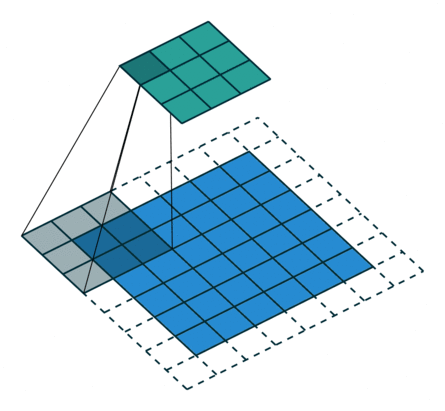

In [ ]:
import torch.nn as nn

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),  # Stride denotes how many steps we are moving in each step in convolution. 
    nn.BatchNorm2d(64),                                                # Padding is a process of adding zeros to the input matrix symmetrically used to to maintain the dimension of output as in input
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32


    # 2D Convolution: in_channels=?, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False
    # Batch Normalization + LeakyReLU with slope 0.2
    nn.Conv2d(None, None, kernel_size=None, stride=None, padding=None, bias=False),
    nn.BatchNorm2d(None),
    nn.LeakyReLU(None, inplace=True),
    # out: 128 x 16 x 16

    # write layer here
     # 2D Convolution: in_channels=?, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False
    # Batch Normalization + LeakyReLU with slope 0.2
    # out: 256 x 8 x 8

    # write layer here
     # 2D Convolution: in_channels=?, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False
    # Batch Normalization + LeakyReLU with slope 0.2
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    # Flatten the previous outputs
    nn.Sigmoid())

# Discriminator Training



Since the discriminator is a binary classification model(Real or Fake), we can use the binary cross entropy loss function to quantify how well it is able to differentiate between real and generated images.


Here are the steps involved in training the discriminator.

We expect the discriminator to output 1 if the image was picked from the real dataset, and 0 if it was generated using the generator network.

We first pass a batch of real images, and compute the loss.

Then we pass a batch of fake images (generated using the generator) pass them into the discriminator, and compute the loss.

Finally we add the two losses and use the overall loss to perform gradient descent to adjust the weights of the discriminator.

It's important to note that we don't change the weights of the generator model while training the discriminator (opt_d only affects the discriminator.parameters())

In [ ]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images) # Add the forward pass
    
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = None # Generator forward pass

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = None # discr forward pass
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

discriminator = to_device(discriminator, device)

# Generator Network

The input to the generator is typically a vector or a matrix of random numbers (referred to as a latent tensor) which is used as a seed for generating an image. The generator will convert a latent tensor of shape (128, 1, 1) into an image tensor of shape 3 x 28 x 28. To achive this, we'll use the ConvTranspose2d layer from PyTorch, which is performs to as a transposed convolution (also referred to as a deconvolution).

In [ ]:
latent_size = 128
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    # Transpose convolution in_features=512, out_features=256, kernel_size=4, stride=2, padding=1
    # Batch Norm and ReLU activation 
    nn.ConvTranspose2d(None, None, kernel_size=None, stride=None, padding=None, bias=False),
    nn.BatchNorm2d(None),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    # 2D Convolution Transpose: in_channels=?, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False
    # Batch Normalization + ReLU
    # out: 128 x 16 x 16

    # 2D Convolution Transpose: in_channels=?, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False
    # Batch Normalization + ReLU
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    # Use Tanh activation
    # out: 3 x 64 x 64
)
generator = to_device(generator, device)

In [ ]:
# lets look at the current generated image 

xb = torch.randn(batch_size, latent_size, 1, 1).to(device) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images.cpu())

# Generator Training 

Since the outputs of the generator are images, it's not obvious how we can train the generator. This is where we employ a rather elegant trick, which is to use the discriminator as a part of the loss function. Here's how it works:

1) We generate a batch of images using the generator, pass the into the 
discriminator.

2) We calculate the loss by setting the target labels to 1 i.e. real. We do this because the generator's objective is to "fool" the discriminator.

3) We use the loss to perform gradient descent i.e. change the weights of the generator, so it gets better at generating real-like images to "fool" the discriminator.

Here's what this looks like in code.

In [ ]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = None # Forward pass for the Generator
    
    # Try to fool the discriminator
    preds = None # forward pass for discriminator
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    # Compute the gradients using .backward() method
    # Perform the Gradient Descent using optimizer.step() for generator optimizer
    
    return loss.item()

# Training the whole thing

Now that we have defined the training functions for the generator and discriminator, we are ready to code the trainer for the whole GAN.

In [ ]:
import torch.nn.functional as F
from tqdm.notebook import tqdm

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache() # getting rid of cache to save memory
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for i, real_images in enumerate(tqdm(train_data_loader)):
            # Train discriminator
            if i%3==0:
                loss_d, real_score, fake_score = None # Add the training function for the Discrimninator
            # Train generator
            loss_g = None # Add the training function for the Generator
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
    return losses_g, losses_d, real_scores, fake_scores

# Test Time !

In [ ]:
fit(epochs=None, lr=None) # set epochs and learning rate(lr)

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1).to(device)
fake_images = None # print a fake image by running xb into generator
print(fake_images.shape)
show_images(fake_images.cpu())